# Ch5. Statistics

### The Normal Distribution

In [1]:
import math
SQRT_TWO_PI = math.sqrt(2 * math.pi)

def normal_pdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (SQRT_TWO_PI * sigma))

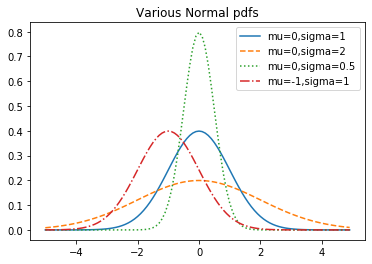

In [2]:
import matplotlib.pyplot as plt
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_pdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_pdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_pdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_pdf(x,mu=-1)   for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend()
plt.title("Various Normal pdfs")
plt.show()

In [3]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

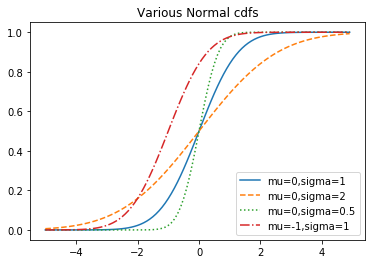

In [4]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
plt.show()

In [5]:
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

### The Central Limit Theorem

In [6]:
import random

def bernoulli_trial(p: float) -> int:
    """Returns 1 with probability p and 0 with probability 1-p"""
    return 1 if random.random() < p else 0

def binomial(n: int, p: float) -> int:
    """Returns the sum of n bernoulli(p) trials"""
    return sum(bernoulli_trial(p) for _ in range(n))

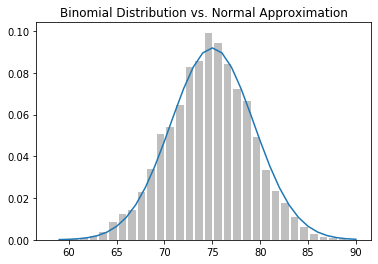

In [7]:
from collections import Counter


def binomial_histogram(p: float, n: int, num_points: int) -> None:
    """Picks points from a Binomial(n, p) and plots their histogram"""
    data = [binomial(n, p) for _ in range(num_points)]

    # use a bar chart to show the actual binomial samples
    histogram = Counter(data)
    plt.bar([x - 0.4 for x in histogram.keys()],
            [v / num_points for v in histogram.values()],
            0.8,
            color='0.75')

    mu = p * n
    sigma = math.sqrt(n * p * (1 - p))

    # use a line chart to show the normal approximation
    xs = range(min(data), max(data) + 1)
    ys = [normal_cdf(i + 0.5, mu, sigma) - normal_cdf(i - 0.5, mu, sigma)
          for i in xs]
    plt.plot(xs,ys)
    plt.title("Binomial Distribution vs. Normal Approximation")
    plt.show()
    
binomial_histogram(0.75, 100, 10000)

# Ch6. Hypothesis and Inference

In [8]:
from typing import Tuple
import math

def normal_approximation_to_binomial(n: int, p: float) -> Tuple[float, float]:
    """Returns mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [9]:
from scratch.probability import normal_cdf

# The normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = normal_cdf

# It's above the threshold if it's not below the threshold
def normal_probability_above(lo: float,
                             mu: float = 0,
                             sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is greater than lo."""
    return 1 - normal_cdf(lo, mu, sigma)

# It's between if it's less than hi, but not less than lo
def normal_probability_between(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is between lo and hi."""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# It's outside if it's not between
def normal_probability_outside(lo: float,
                               hi: float,
                               mu: float = 0,
                               sigma: float = 1) -> float:
    """The probability that an N(mu, sigma) is not between lo and hi."""
    return 1 - normal_probability_between(lo, hi, mu, sigma)

<Figure size 432x288 with 0 Axes>

In [10]:
from scratch.probability import inverse_normal_cdf

def normal_upper_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float,
                       mu: float = 0,
                       sigma: float = 1) -> float:
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float,
                            mu: float = 0,
                            sigma: float = 1) -> Tuple[float, float]:
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2

    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)

    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [11]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


In [12]:
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lower_bound, upper_bound)

469.01026640487555 530.9897335951244


In [13]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(lo, hi)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(mu_1, sigma_1)

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.887
print(power)

469.01026640487555 530.9897335951244
550.0 15.732132722552274
0.8865480012953671


In [14]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 (< 531, since we need more probability in the upper tail)

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.936
print(power)

0.9363794803307173


In [15]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.51)
print(mu_1, sigma_1)

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability      # 0.887
print(power)

510.0 15.8082257068907
0.09688458187649163


### p-value

In [16]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """
    How likely are we to see a value at least as extreme as x (in either
    direction) if our values are from an N(mu, sigma)?
    """
    if x >= mu:
        # x is greater than the mean, so the tail is everything greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        # x is less than the mean, so the tail is everything less than x
        return 2 * normal_probability_below(x, mu, sigma)

In [17]:
# 529.5 instead of 530 -> continuity correction
two_sided_p_value(529.5, mu_0, sigma_0)   # 0.062

0.06207721579598857

In [18]:
import random

extreme_value_count = 0
for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0    # Count # of heads
                    for _ in range(1000))                # in 1000 flips,
    if num_heads >= 530 or num_heads <= 470:             # and count how often
        extreme_value_count += 1                         # the # is 'extreme'

# p-value was 0.062 => ~62 extreme values out of 1000
# assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

# what is the use of extreme_value_count? actual test results
# why 59~65? it seems it's just an arbitrary number around 62.
extreme_value_count

58

In [19]:
two_sided_p_value(531.5, mu_0, sigma_0)   # 0.0463

0.046345287837786575

### Confidence Interval

In [20]:
# standard deviation when mean is 525 
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)   # 0.0158

In [21]:
# we can have 95% confidence that 
# the coin is in the range of the pair coin (500)
# since the range is 494~556
normal_two_sided_bounds(0.95, mu, sigma)        # [0.4940, 0.5560]

(0.4940490278129096, 0.5559509721870904)

In [22]:
# In this case we can reject the null hyphothesis 
# since the 95% confidence interval range is outside of 500, 
# the pair coin range.
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]

(0.5091095927295919, 0.5708904072704082)

### p-Hacking

In [23]:
from typing import List

def run_experiment() -> List[bool]:
    """Flips a fair coin 1000 times, True = heads, False = tails"""
    return [random.random() < 0.5 for _ in range(1000)]

def reject_fairness(experiment: List[bool]) -> bool:
    """Using the 5% significance levels"""
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len([experiment
                      for experiment in experiments
                      if reject_fairness(experiment)])

num_rejections

46

### Example: Running an A/B Test

In [24]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

In [25]:
# standard normal - what is it?
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [26]:
z = a_b_test_statistic(1000, 200, 1000, 180)    # -1.14

In [27]:
two_sided_p_value(z)                            # 0.254

0.254141976542236

In [28]:
z = a_b_test_statistic(1000, 200, 1000, 150)    # -2.94
two_sided_p_value(z)                            # 0.003

0.003189699706216853

### Bayesian Inference

In [29]:
def B(alpha: float, beta: float) -> float:
    """A normalizing constant so that the total probability is 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:          # no weight outside of [0, 1]
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

# Ch 10. Working with data

## Exploring Your Data

### Exploring One-Dimensional Data

In [30]:
from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [31]:
import random
from scratch.probability import inverse_normal_cdf

random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)]

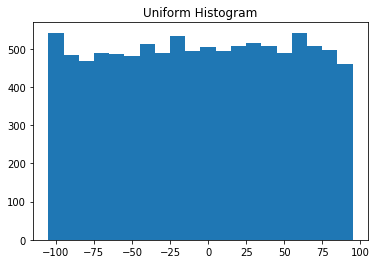

In [32]:
plot_histogram(uniform, 10, "Uniform Histogram")

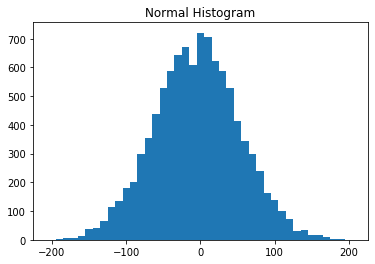

In [33]:
plot_histogram(normal, 10, "Normal Histogram")

### Two Dimensions

In [34]:
def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

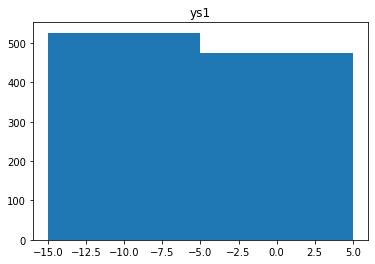

In [35]:
# ??? wrong histogram in the book
plot_histogram(ys1, 10, "ys1")

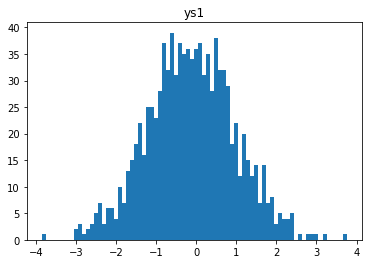

In [48]:
plot_histogram(ys1, 0.1, "ys1")

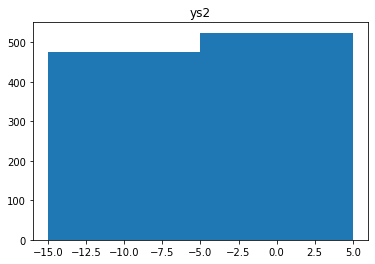

In [36]:
plot_histogram(ys2, 10, "ys2")

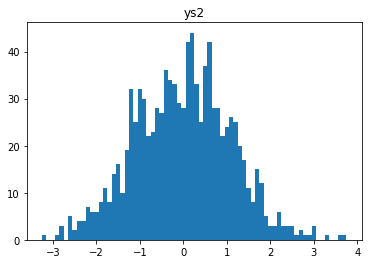

In [49]:
plot_histogram(ys2, 0.1, "ys2")

In [43]:
inverse_normal_cdf(0)

-9.999990463256836

In [40]:
inverse_normal_cdf(0.2)

-0.8416271209716797

In [44]:
inverse_normal_cdf(1)

8.244009017944336

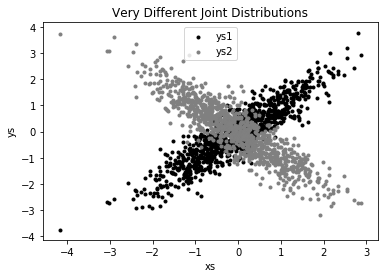

In [42]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

0.9010493686379609
-0.8920981526880033


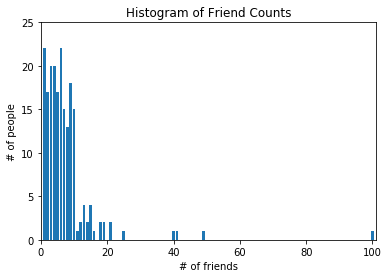

In [50]:
from scratch.statistics import correlation

print(correlation(xs, ys1))      # about 0.9
print(correlation(xs, ys2))      # about -0.9

### Many Dimensions

In [51]:
from scratch.linear_algebra import Matrix, Vector, make_matrix

# TODO: Correlation takes two lists. Are data[i] and data[j] lists?
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]
    """
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])

    return make_matrix(len(data), len(data), correlation_ij)

## Using NamedTuples

In [53]:
import datetime

# more memory consumption and error-prone key
stock_price = {'closing_price': 102.06,
               'date': datetime.date(2014, 8, 29),
               'symbol': 'AAPL'}

In [54]:
from collections import namedtuple

# no type hints
StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

In [55]:
# typed variant
from typing import NamedTuple

# Very few people use NamedTuple in this way. But they should!
class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## Dataclasses

In [57]:
# from Python 3.7
# mutable
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == 'MSFT'
assert price2.closing_price == 106.03
assert price2.is_high_tech()

ModuleNotFoundError: No module named 'dataclasses'

## Cleaning and Munging

In [58]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

# Now test our function
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [59]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

# Should return None for errors
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

# But should return same as before if data is good
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

## Manipulating Data

In [60]:
# skip

## Rescaling

In [61]:
# rescale each dimension => mean 0, standard deviation 1

In [62]:
from typing import Tuple

from scratch.linear_algebra import vector_mean
from scratch.statistics import standard_deviation

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """returns the mean and standard deviation for each position"""
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]

    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [63]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]

    return rescaled

In [64]:
means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

## An Aside: tqdm

In [66]:
import tqdm

for i in tqdm.tqdm(range(100)):
    # do something slow
    _ = [random.random() for _ in range(1000000)]

100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


In [67]:
# primes info
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)

            t.set_description(f"{len(primes)} primes")

    return primes

my_primes = primes_up_to(100_000)

9592 primes: 100%|██████████| 99997/99997 [01:55<00:00, 864.23it/s] 


## Dimensionality Reduction

In [1]:
# skip

# Ch 17. Decision Trees

In [4]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    return sum(-p * math.log(p, 2)
              for p in class_probabilities
              if p > 0)

print(entropy([1]))
print(entropy([.5]))
print(entropy([.5, .5]))
print(entropy([.25, .75]))
print(entropy([.5, .5, .5])) # impossible scenario

0.0
0.5
1.0
0.8112781244591328
1.5


In [8]:
from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

print(data_entropy(['a']))
print(data_entropy(['a', 'b', 'a']))
print(data_entropy(['a', 'b']))

0.0
0.9182958340544896
1.0


## The Entropy of Partition

q: proportion,
H: entropy,
S: subset

H=q1H(S1)+...+qmH(Sm)

In [10]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)